## **Dataset visualization and extraction from ESRF .h5 files**
- Version: 1.2 | Author: William Rigaut | Date: 26.11.2024
- Tested on MacOS Ventura 13.4.1 and Python 3.12.3

This code is designed to extract and visualize data from the European Synchrotron Radiation Facility (ESRF) at beamline BM02.

The module contains:
- Functions for extracting and visualizing data from the raw .h5data files
- Functions for extracting and visualizing data from the processed .h5 files
- Functions for saving data to .xy files

### **1. Import librairy and setup**

Firstly you can create a set of folders where your data will be stored and extracted. I recommand creating a main folder called `ESRF_data` containing three subfolder :
- `RAW_DATA` : Folder contaning the raw XRD data from the 2D camera
- `PROCESSED_DATA` : Folder containing the 1D spectra from integrated 2D images
- `SAVED_DATA` : Output folder containing .xy 1D spectra for each position

In [36]:
# Defining our paths with pathlib librairy
import pathlib as pl

main_folder = "ESRF_data"

raw_data_path = pl.Path(main_folder + '/' + "RAW_DATA")
processed_data_path = pl.Path(main_folder + '/' + "PROCESSED_DATA")
saved_data_path = pl.Path(main_folder + '/' "SAVED_DATA")

Then you can import the package `extract_esrf` to create these folders for you with :

In [37]:
# Making folders with create_folders() function from extract_esrf library
import packages.extract_esrf.extract_esrf as ee

ee.create_folders(main_folder,
                  raw_data_path, processed_data_path, saved_data_path)

Creating folder ESRF_data
Folder ESRF_data already exists.
Creating folder ESRF_data/RAW_DATA
Folder ESRF_data/RAW_DATA already exists.
Creating folder ESRF_data/PROCESSED_DATA
Folder ESRF_data/PROCESSED_DATA already exists.
Creating folder ESRF_data/SAVED_DATA
Folder ESRF_data/SAVED_DATA already exists.


Now that everything is setup you can download or import your raw data files from ESRF in the `RAW_DATA/` and `PROCESSED_DATA/` directories.

<span style="color: red;">Disclamer: You need to have both raw and processed data in order for the notebook to run properly.</span>

### **2. Data visualization and data extraction**

You can define the variable `foldername` to be the folder that contains the data you want to see, here is an example with NdFeB_7-17 dataset for the scan number 31:

In [38]:
foldername="CeCoZn_4_7_v2"
scan_number=8

Then you can call the function `extract_CdTe_data()` by specifiying both the foldername and the scan_number in argument. A few details about this function :
- The function actually returns an array containing the count on each pixel of the 2D camera. You can eventually save the content of image_2D if needed.
- You can disable the plotting by setting display to False with the code `ee.extract_CdTe_data(foldername, scan_number, display=False)`.
- If you are using a path for the raw data that is different from the one previously suggested you must pass in argument `raw_data_path=your_custom_path` so that the function knows where to look for the data.
- Note that in the 2D camera datasets, the first 26 scans are corresponding to z and theta alignements along the wafer, the first acquired position starts at `scan_number=27` and the last at `scan_number=315`.

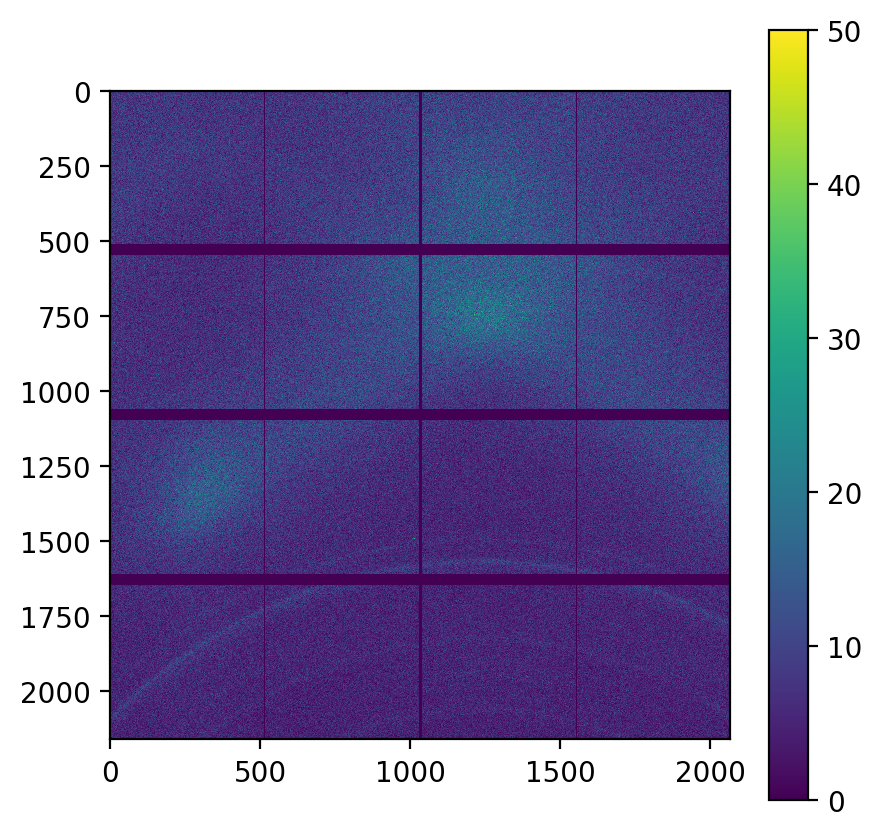

In [39]:
image_2D, metadata = ee.extract_CdTe_data(foldername, scan_number, display=True, output_metadata=True, raw_data_path=raw_data_path)

A very similar `function extract_integrated_data()` can be used to display the 1D integrated image data like this :

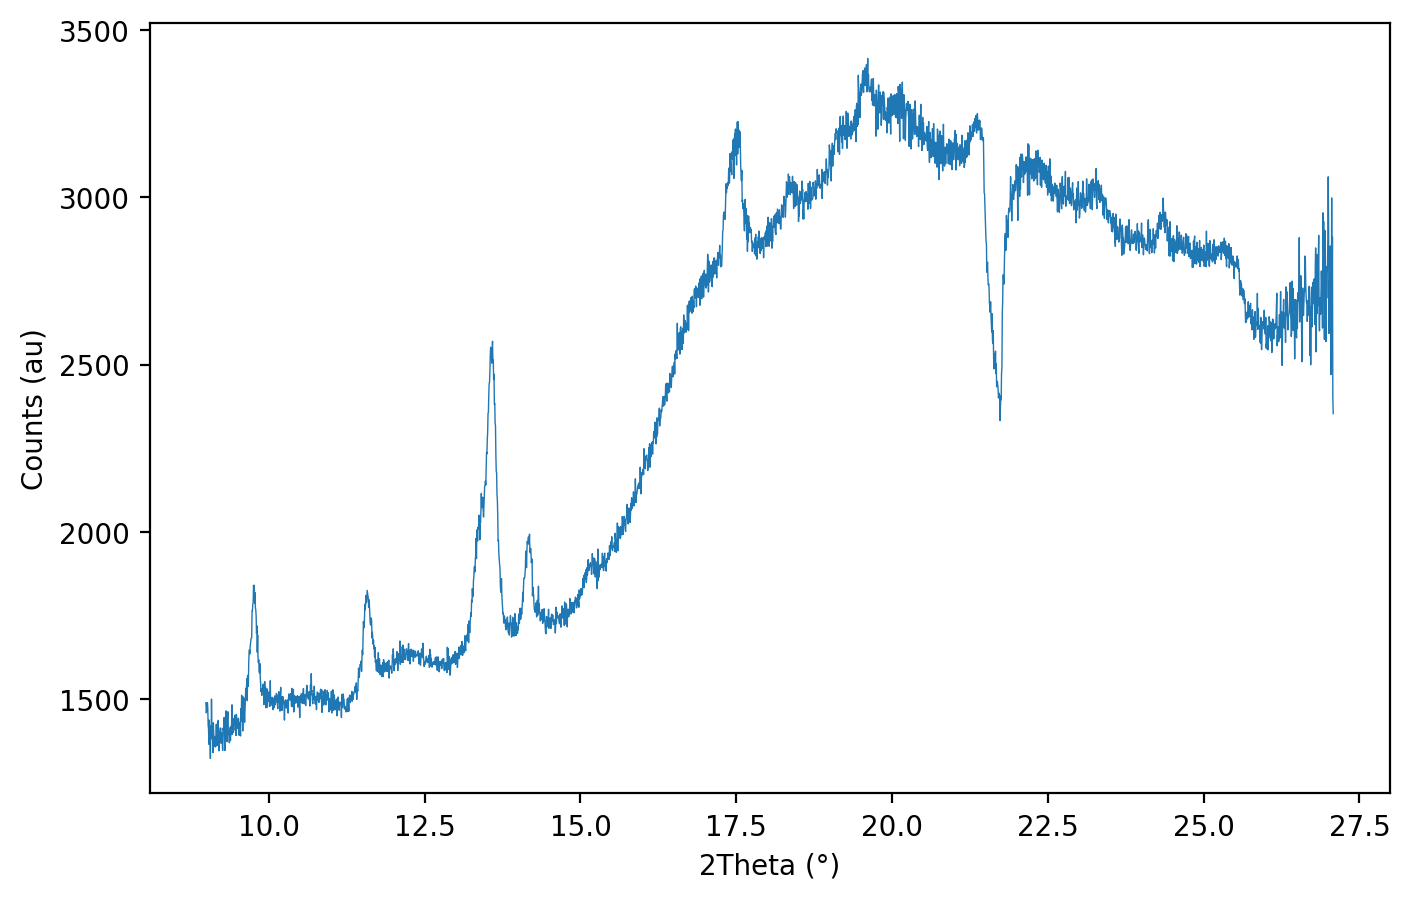

In [40]:
spectra_1D = ee.extract_integrated_data(foldername, scan_number, display=True, processed_data_path=processed_data_path)

You can then simply save the spectra using the function `save_integrated_data()` by passing first both the `foldername` and the `scan_number` as argument to generate a .xy file with a proper filename and then the `spectra_1D` you want to save. A few points :
- The x values saved are q values (in Å^-1) converted to 2θ angle by knowing the beam energy (25 keV).
- In the .h5 integrated data, counts at each angle are calculated by summing all the pixels intensities and normalized by the total number of pixels. In the library, the y values are arbitrary rescaled with a factor of 1000 to make it easier to read in Profex. The final unit for the counts should be counts/pixel*10^3.

In [6]:
ee.save_integrated_data(foldername, scan_number, spectra_1D, saved_data_path=saved_data_path)

If you want to save all the data from the dataset (excluding the calibration points) you can use instead `save_all_integrated()` by specifiying the `foldername` and all three paths `raw_data_path`, `processed_data_path`, `saved_data_path` to the function.

- The function will read all the scans from number 27 to 315 (25 to 274 for new scans), excluding the z and theta scans from calibration
- Metadata is copied from the raw data fils and written in the header of each .xy files.

In [7]:
ee.save_all_integrated(foldername,
    raw_data_path=raw_data_path,
    processed_data_path=processed_data_path,
    saved_data_path=saved_data_path,
    custom_range=range(25, 274))

100%|██████████| 52/52 [00:09<00:00,  5.61it/s]

All .xy spectrum saved in ESRF_data/SAVED_DATA/CeCoZn_4_7_v2 succesfully !


The same can be done with the images using the function `save_all_images()` where you need to pass in arguments the `foldername`, the `raw_data_path` and the `savec_data_path`.

- By default the function will only read measurement data which includes scans from number 27 to 315, but a `custom_range` can be specified using the `range(start, stop)` function.
- The image is saved using the FabIO library, and his saved as .img by default. Format can be changed with the `custom_format` parameter. A list of all FabIO compatible formats can be found here: http://www.silx.org/doc/fabio/latest/getting_started.html#list-of-file-formats-that-fabio-can-read-and-write

In [8]:
ee.save_all_images(
    foldername,
    raw_data_path="./ESRF_data/RAW_DATA/",
    saved_data_path="./ESRF_data/SAVED_DATA/",
    custom_range=range(25, 274))

100%|██████████| 52/52 [00:08<00:00,  6.27it/s]

All CdTe data saved in ESRF_data/SAVED_DATA/CeCoZn_4_7_v2 succesfully !


You can then read the .img files using the `fabio` python module. Here is a advanced example using interactive sliders to display images:

In [31]:
# Reads .img files with fabio and display with pylab
import fabio
import pathlib as pl
import ipywidgets as widgets
import matplotlib.pyplot as plt
from pylab import figure, cm
from matplotlib.colors import LogNorm, Normalize
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider


folderpath_str = "ESRF_data/SAVED_DATA/YFeTa/YFeTa_3_1"
#folderpath_str = "ESRF_data/SAVED_DATA/CeCoX/CeCoZn_4_7"
#folderpath_str = "ESRF_data/SAVED_DATA/NdXFeB-magnetron/NdCeFeB_2_7"

def plot_img(folderpath_str, index):
    folderpath = pl.Path(folderpath_str)
    filepath = folderpath / f"{folderpath.name}_{index}.img"
    img_file = fabio.open(filepath)

    f = figure(figsize=(6, 4), dpi=200)
    ax = f.add_axes([0, 0, 1, 1])
    #im = ax.matshow(img_file.data, cmap=cm.rainbow, norm=Normalize(vmin=220, vmax=500), aspect='2') # Linear scale
    #im = ax.matshow(img_file.data, cmap=cm.rainbow, norm=LogNorm(vmin=1, vmax=2000), aspect='2') # Log scale
    im = ax.matshow(img_file.data, cmap=cm.rainbow, norm=Normalize(vmin=0, vmax=60))
    f.colorbar(im, format='%1.0f')

interact(plot_img, folderpath_str=folderpath_str, index=IntSlider(min=25, max=273, step=1, value=25))

interactive(children=(Text(value='ESRF_data/SAVED_DATA/YFeTa/YFeTa_3_1', description='folderpath_str'), IntSli…

<function __main__.plot_img(folderpath_str, index)>

The follwing function `fuse_all_img()` will merge all of the images in a folder. You can customize the selection with the argument `idx_range`, default value is `range(25, 274)`:

In [32]:
def fuse_all_img(folderpath_str, idx_range=range(25, 274)):
    folderpath = pl.Path(folderpath_str)

    fused_img = []
    for index in idx_range:
        try:
            filepath = folderpath / f"{folderpath.name}_{index}.img"
            img_file = fabio.open(filepath)

            if len(fused_img) == 0:
                fused_img = img_file.data
            else:
                fused_img += img_file.data
        except FileNotFoundError:
            print(f"Warning, img file not found at position {index}")
    
    return fused_img

fused_img = fuse_all_img(folderpath_str)


You can use this following code to plot the fused image :

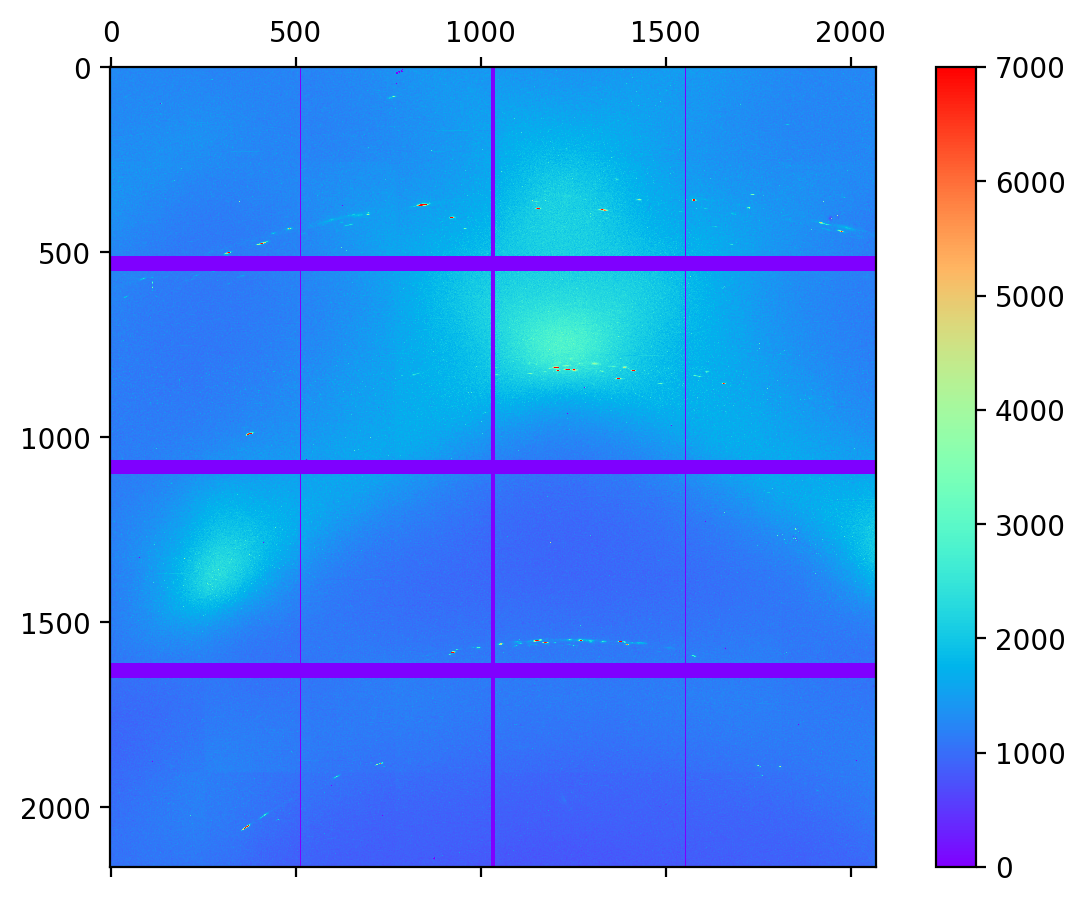

In [33]:
f = figure(figsize=(6, 4), dpi=200)
ax = f.add_axes([0, 0, 1, 1])
#im = ax.matshow(fused_img, cmap=cm.rainbow, norm=Normalize(vmin=220, vmax=500), aspect='2') # Linear scale
#im = ax.matshow(fused_img, cmap=cm.rainbow, norm=LogNorm(vmin=1, vmax=50000)) # Log scale
im = ax.matshow(fused_img, cmap=cm.rainbow, norm=Normalize(vmin=0, vmax=7000))
f.colorbar(im, format='%1.0f')